In [181]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from config import fred_apikey
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [182]:
coin_pair = "eth-usd"
df = yf.download(coin_pair, progress=False)
df = df.loc[:, ["Close"]]

df.head()

Price,Close
Ticker,ETH-USD
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [183]:
df["Simple Return"] = df["Close"].pct_change()
df["Log Return"] = np.log(df["Close"]/df["Close"].shift(1))

df.head()

Price,Close,Simple Return,Log Return
Ticker,ETH-USD,,
Date,,,
2017-11-09,320.884003,NaN,NaN
2017-11-10,299.252991,-0.067411,-0.069790
2017-11-11,314.681000,0.051555,0.050270
2017-11-12,307.907990,-0.021523,-0.021758
2017-11-13,316.716003,0.028606,0.028204


In [184]:
df.columns = df.columns.get_level_values(0)
df_monthly = df.resample('M').last()

df_monthly.head()

Price,Close,Simple Return,Log Return
Date,,,
2017-11-30,447.114014,0.045824,0.044806
2017-12-31,756.732971,0.055037,0.053576
2018-01-31,1118.310059,0.044047,0.043104
2018-02-28,855.198975,-0.026263,-0.026614
2018-03-31,396.457001,0.004591,0.004581


In [185]:
fred = Fred(api_key=fred_apikey)
cpi = fred.get_series('CPIAUCSL', observation_start='2017-11-09')
cpi.index.name = 'Date'

cpi_monthly = cpi.resample('M').last().to_frame(name='CPI')

cpi_monthly.head()

,CPI
Date,
2017-11-30,247.284
2017-12-31,247.805
2018-01-31,248.859
2018-02-28,249.529
2018-03-31,249.577


In [186]:
df_monthly = df_monthly.join(cpi_monthly, how='left')

df_monthly["Inflation Rate"] = df_monthly["CPI"].pct_change()

df_monthly["Real Return"] = (
    (df_monthly["Simple Return"] + 1) / (df_monthly["Inflation Rate"] + 1) - 1
)

df_monthly.head()

,Close,Simple Return,Log Return,CPI,Inflation Rate,Real Return
Date,,,,,,
2017-11-30,447.114014,0.045824,0.044806,247.284,NaN,NaN
2017-12-31,756.732971,0.055037,0.053576,247.805,0.002107,0.052819
2018-01-31,1118.310059,0.044047,0.043104,248.859,0.004253,0.039625
2018-02-28,855.198975,-0.026263,-0.026614,249.529,0.002692,-0.028878
2018-03-31,396.457001,0.004591,0.004581,249.577,0.000192,0.004398


In [187]:
def realize_volatility(x):
    return np.sqrt(np.sum(x**2))

In [188]:
df_rv = (
    df_monthly.groupby(pd.Grouper(freq='M'))
    .apply(realize_volatility)
    .rename(columns={'Log Return': 'Realized Volatility'})
)

df_rv.head()

,Close,Simple Return,Realized Volatility,CPI,Inflation Rate,Real Return
Date,,,,,,
2017-11-30,447.114014,0.045824,0.044806,247.284,0.000000,0.000000
2017-12-31,756.732971,0.055037,0.053576,247.805,0.002107,0.052819
2018-01-31,1118.310059,0.044047,0.043104,248.859,0.004253,0.039625
2018-02-28,855.198975,0.026263,0.026614,249.529,0.002692,0.028878
2018-03-31,396.457001,0.004591,0.004581,249.577,0.000192,0.004398


In [189]:
df_rv["Anual Realized Volatility"] = df_rv["Realized Volatility"] * np.sqrt(12)

df_rv.head()

,Close,Simple Return,Realized Volatility,CPI,Inflation Rate,Real Return,Anual Realized Volatility
Date,,,,,,,
2017-11-30,447.114014,0.045824,0.044806,247.284,0.000000,0.000000,0.155211
2017-12-31,756.732971,0.055037,0.053576,247.805,0.002107,0.052819,0.185593
2018-01-31,1118.310059,0.044047,0.043104,248.859,0.004253,0.039625,0.149318
2018-02-28,855.198975,0.026263,0.026614,249.529,0.002692,0.028878,0.092194
2018-03-31,396.457001,0.004591,0.004581,249.577,0.000192,0.004398,0.015869


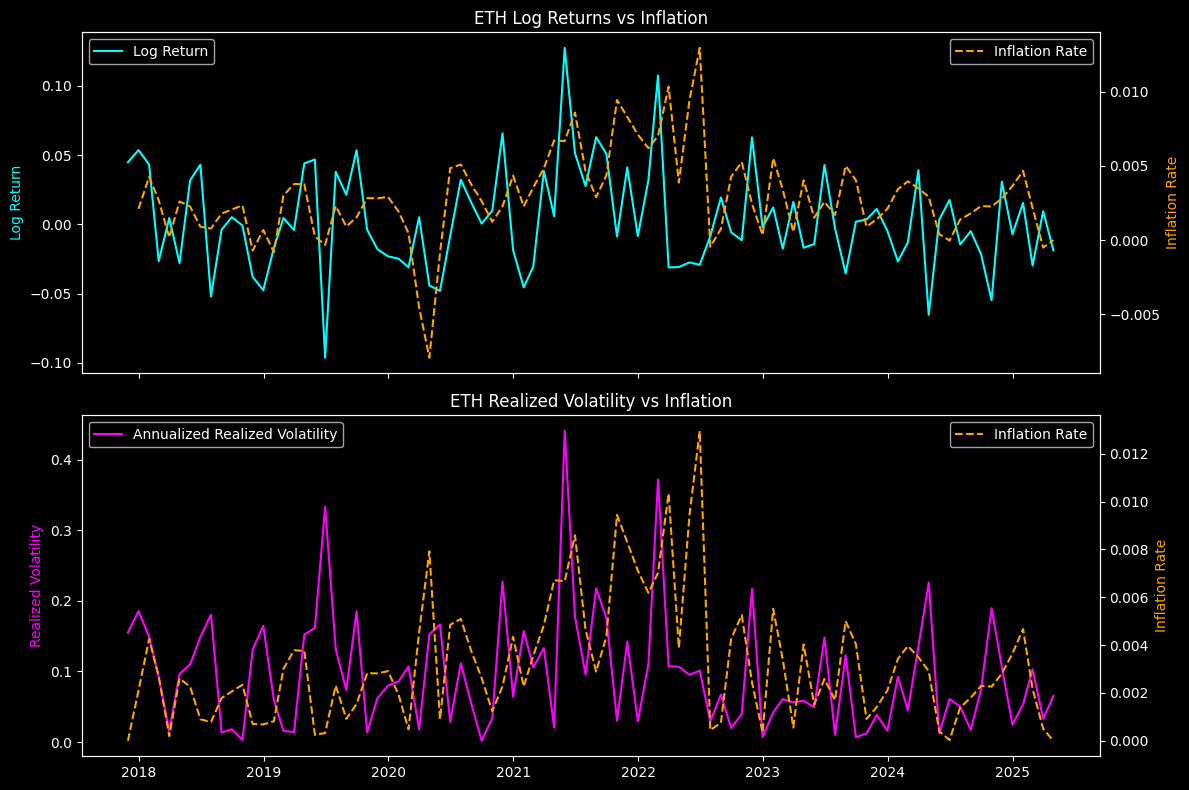

In [190]:
# Optional dark mode
plt.style.use('dark_background')

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Subplot 1: Log Returns + Inflation
ax[0].plot(df_monthly.index, df_monthly['Log Return'], color='cyan', label='Log Return')
ax0_twin = ax[0].twinx()
ax0_twin.plot(df_monthly.index, df_monthly['Inflation Rate'], color='orange', linestyle='--', label='Inflation Rate')

ax[0].set_title("ETH Log Returns vs Inflation")
ax[0].set_ylabel("Log Return", color='cyan')
ax0_twin.set_ylabel("Inflation Rate", color='orange')

# Legends
ax[0].legend(loc='upper left')
ax0_twin.legend(loc='upper right')

# Subplot 2: Realized Volatility + Inflation
ax[1].plot(df_rv.index, df_rv['Anual Realized Volatility'], color='magenta', label='Annualized Realized Volatility')
ax1_twin = ax[1].twinx()
ax1_twin.plot(df_rv.index, df_rv['Inflation Rate'], color='orange', linestyle='--', label='Inflation Rate')

ax[1].set_title("ETH Realized Volatility vs Inflation")
ax[1].set_ylabel("Realized Volatility", color='magenta')
ax1_twin.set_ylabel("Inflation Rate", color='orange')

# Legends
ax[1].legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Shared settings
plt.xlabel("Date")
plt.tight_layout()
plt.show()